<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/deepxde_mix_old_new_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Approximation of Hill-Type ODE

- ODE: $ \displaystyle \frac{dx}{dt} = \frac{x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}} $
- Condition: $ x(0) \approx b $, where $ b > 0 $ and $ \alpha \rightarrow 0 $ (stiff regime)
- Neural Solvers: PINNs with FNNs (32x4, 64x4)
- Baselines: RK45, BDF, Radau (SciPy)
- Focus: Accuracy around $ t \approx 0 $, where stiffness dominates

# 🧠 PINNs Meet Hill-Like ODEs  
**Can neural nets compete with trusted numerical solvers? Let's find out!**

- **ODE form**:  
  $ \displaystyle \frac{dx}{dt} = \frac{x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}} $ — steep, stiff, and nonlinear!
- **Setup**:
  - Initial state: $ x(0) \approx b $
  - We're in the $ \alpha \rightarrow 0 $ world (very sharp transitions).
- **Neural Nets**:
  - Feedforward networks (FNNs) trained via DeepXDE.
  - Multiple architectures tested: 32x4, 64x4, etc.
- **Numerical Solvers**:
  - `RK45` for adaptive precision  
  - `BDF` for stiffness  
  - `Radau` for stability  
- **Goal**: See how well PINNs approximate fast-changing dynamics vs. classical ODE solvers.


In [ ]:
# Parameters
#alpha = 0.01
alpha_list = np.logspace(-2, -5, 10)  # от 0.01 до 0.00001 логарифмически

b = 1.0
x0 = b * 0.99999  # Initial condition x(0) ≈ b
nonuniformity_power = 3.0  # Controls how dense the points are near t = 1 (higher = denser)


!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


Sample RK45 values:
[0.         0.00599998 0.01197592 0.01792786 0.02385584] [0.99999    1.0032568  1.00702317 1.01124703 1.01588037]

Sample BDF values:
[0.         0.00599998 0.01197592 0.01792786 0.02385584] [0.99999    1.00361473 1.0075202  1.01207391 1.01680256]

Sample Radau values:
[0.         0.00599998 0.01197592 0.01792786 0.02385584] [0.99999    1.00316267 1.00693267 1.01120182 1.01587418]

Training model: FNN 32x4, domain=500
Compiling model...
Building feed-forward neural network...
'build' took 0.369947 s

'compile' took 3.784312 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.49e-01, 1.00e-10]    [2.49e-01, 1.00e-10]    []  
1000      [2.18e-03, 7.40e-04]    [2.15e-03, 7.40e-04]    []  
2000      [9.62e-04, 1.18e-03]    [9.50e-04, 1.18e-03]    []  
3000      [6.37e-04, 1.29e-03]    [6.30e-04, 1.29e-03]    []  
4000      [4.58e-04, 1.36e-03]    [4.55e-04, 1.36e-03]    []  
5000      [3.89e-04, 1.41e-03]    [3.86e-0

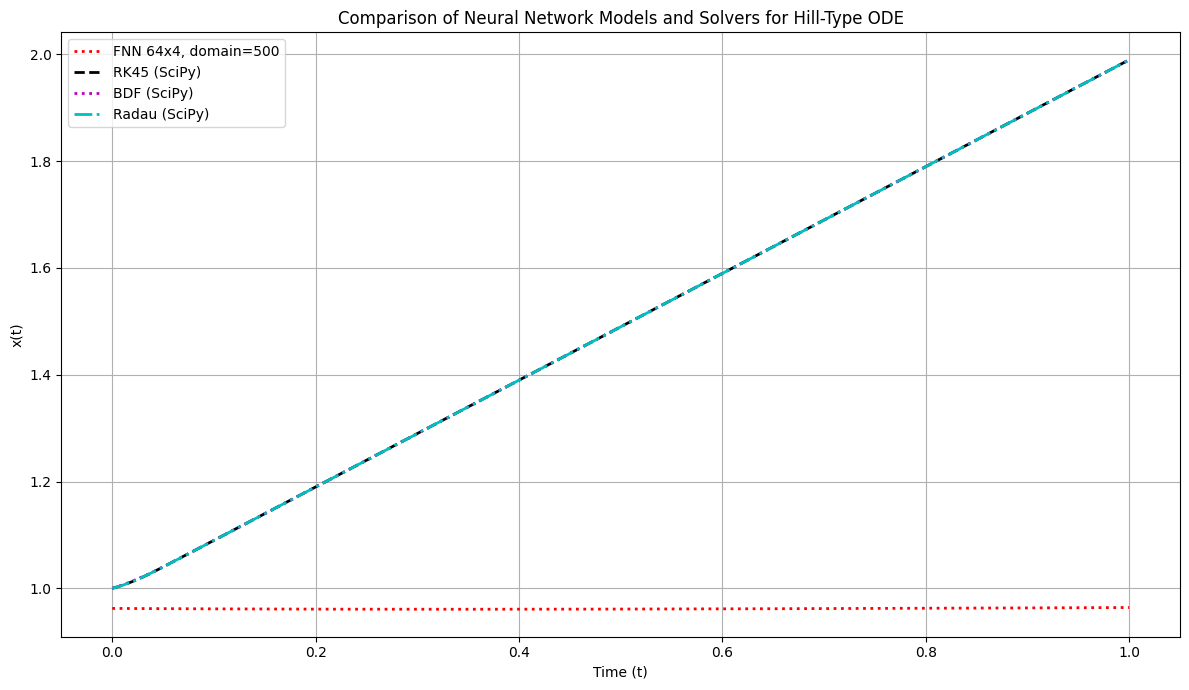

In [14]:
# Solution of ODE with Hill-like RHS: model comparison and approximation

# ODE with Hill-like RHS
def get_hill_equation(alpha):
  def hill_equation(x, y):
     y_safe = tf.clip_by_value(y, 1e-6, 1e6)
     dy_t = dde.grad.jacobian(y, x, i=0, j=0) # dy/dt
     x_alpha = tf.pow(y_safe, 1 / alpha)      # x^(1/alpha)
     b_alpha = tf.pow(b, 1 / alpha)           # b^(1/alpha)
     return dy_t - x_alpha / (b_alpha + x_alpha)
  return hill_equation


# Time domain geometry
geom = dde.geometry.TimeDomain(0, 1)

# Initial condition
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Model configurations to compare
#configs = [
#    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
#    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
#    (500, [1] + [128] * 6 + [1], "FNN 128x6, domain=500"),
#    (1000, [1] + [128] * 6 + [1], "FNN 128x6, domain=1000"),
#    (500, [1] + [128] * 8 + [1], "FNN 128x8, domain=500"),
#    (1000, [1] + [128] * 8 + [1], "FNN 128x8, domain=1000")
#]

configs = [
#    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
#    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
    (500, [1] + [64] * 4 + [1], "FNN 64x4, domain=500"),
]

# Prepare test time points (dense near t=0)
# Non-uniform test points: dense near t=0
N = 500
t_uniform = np.linspace(0, 1, N)  # Uniform grid in [0, 1]

# Skew distribution toward t=1: more points near 1, fewer near 0
t_test = 1 - (1 - t_uniform) ** nonuniformity_power

t_test = np.unique(t_test).reshape(-1, 1)  # Ensure strictly increasing and 2D


# Define RHS for SciPy integration
def rhs(t, x):
    x_safe = np.clip(x[0], 1e-6, 1e6)
    x_alpha = x_safe ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return [x_alpha / (b_alpha + x_alpha)]

# Plot all models
plt.figure(figsize=(12, 7))

# Solve using different stiff solvers
t_eval = np.sort(t_test.flatten())
sol_rk45 = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method='RK45')
sol_bdf = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method='BDF')
sol_radau = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method='Radau')

# Show some sample values in console
print("\nSample RK45 values:")
print(sol_rk45.t[:5], sol_rk45.y[0][:5])
print("\nSample BDF values:")
print(sol_bdf.t[:5], sol_bdf.y[0][:5])
print("\nSample Radau values:")
print(sol_radau.t[:5], sol_radau.y[0][:5])

# Line styles and colors for plotting
styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
colors = ['b', 'g', 'r', 'c', 'm', 'k']

# Train and evaluate neural models
results = []
for i, (num_domain, architecture, label) in enumerate(configs):
    print(f"\nTraining model: {label}")
    data = dde.data.PDE(
        geom,
        get_hill_equation(alpha),
        ic,
        num_domain=num_domain,
        num_boundary=2,
        num_test=500
    )
    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")
    net.apply_output_transform(lambda x, y: y * 0.01 + b)
    model = dde.Model(data, net)
    model.compile("adam", lr=0.0001)
    model.train(iterations=5000, display_every=1000, disregard_previous_best=True)
    try:
        model.compile("L-BFGS")
        model.train(iterations=500)
    except Exception as e:
        print(f"L-BFGS failed for {label}: {str(e)}")
    x_pred = model.predict(t_test)
    results.append((t_test, x_pred, label))
    print(f"{label}: min={np.nanmin(x_pred):.4f}, max={np.nanmax(x_pred):.4f}")

# Save results for later visualization
#import pickle
#with open("nn_results.pkl", "wb") as f:
#    pickle.dump(results, f)

    plt.plot(t_test, x_pred,
            linestyle=styles[i % len(styles)], color=colors[i % len(colors)],
            label=f"{label}, α={alpha:.1e}",
            linewidth=2)

# Add numerical solutions
#plt.plot(sol_rk45.t, sol_rk45.y[0], 'k--', label='RK45 (SciPy)', linewidth=2)
#plt.plot(sol_bdf.t, sol_bdf.y[0], 'm:', label='BDF (SciPy)', linewidth=2)
#plt.plot(sol_radau.t, sol_radau.y[0], 'c-.', label='Radau (SciPy)', linewidth=2)

# Axis and title
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models and Solvers for Hill-Type ODE")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(0.95, 0.975)
#plt.xlim(0, 0.02)
plt.show()

In [ ]:
# Visualization block (can be run separately)
import pickle
with open("nn_results.pkl", "rb") as f:
    results = pickle.load(f)

plt.figure(figsize=(12, 7))
for i, (t_vals, x_vals, label) in enumerate(results):
    plt.plot(t_vals, x_vals, linestyle=styles[i % len(styles)], color=colors[i % len(colors)], label=label, linewidth=2)

plt.plot(sol_rk45.t, sol_rk45.y[0], 'k--', label='RK45 (SciPy)', linewidth=2)
plt.plot(sol_bdf.t, sol_bdf.y[0], 'm:', label='BDF (SciPy)', linewidth=2)
plt.plot(sol_radau.t, sol_radau.y[0], 'c-.', label='Radau (SciPy)', linewidth=2)

plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models and Solvers for Hill-Type ODE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 0.02)
plt.show()

test temp block


Sample RK45 values:
[0.00000000e+00 8.04819264e-09 6.43855411e-08 2.17301201e-07
 5.15084329e-07] [0.99999    0.99999    0.99999003 0.99999011 0.99999026]

Sample BDF values:
[0.00000000e+00 8.04819264e-09 6.43855411e-08 2.17301201e-07
 5.15084329e-07] [0.99999    0.99999    0.99999003 0.99999011 0.99999026]

Sample Radau values:
[0.00000000e+00 8.04819264e-09 6.43855411e-08 2.17301201e-07
 5.15084329e-07] [0.99999    0.99999    0.99999003 0.9999901  0.99999024]

Training model: FNN 32x4, domain=500
Compiling model...
Building feed-forward neural network...
'build' took 0.186186 s

'compile' took 1.206523 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.49e-01, 1.00e-10]    [2.49e-01, 1.00e-10]    []  
1000      [2.18e-03, 7.40e-04]    [2.15e-03, 7.40e-04]    []  
2000      [9.62e-04, 1.18e-03]    [9.50e-04, 1.18e-03]    []  
3000      [6.37e-04, 1.29e-03]    [6.30e-04, 1.29e-03]    []  
4000      [4.58e-04, 1.36e-03]    [4.55e-0

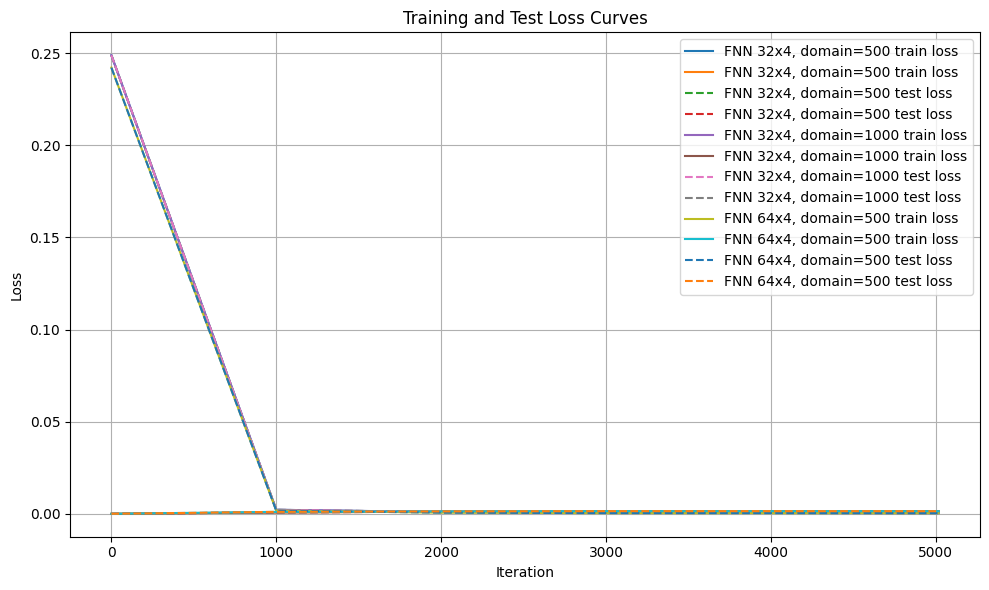

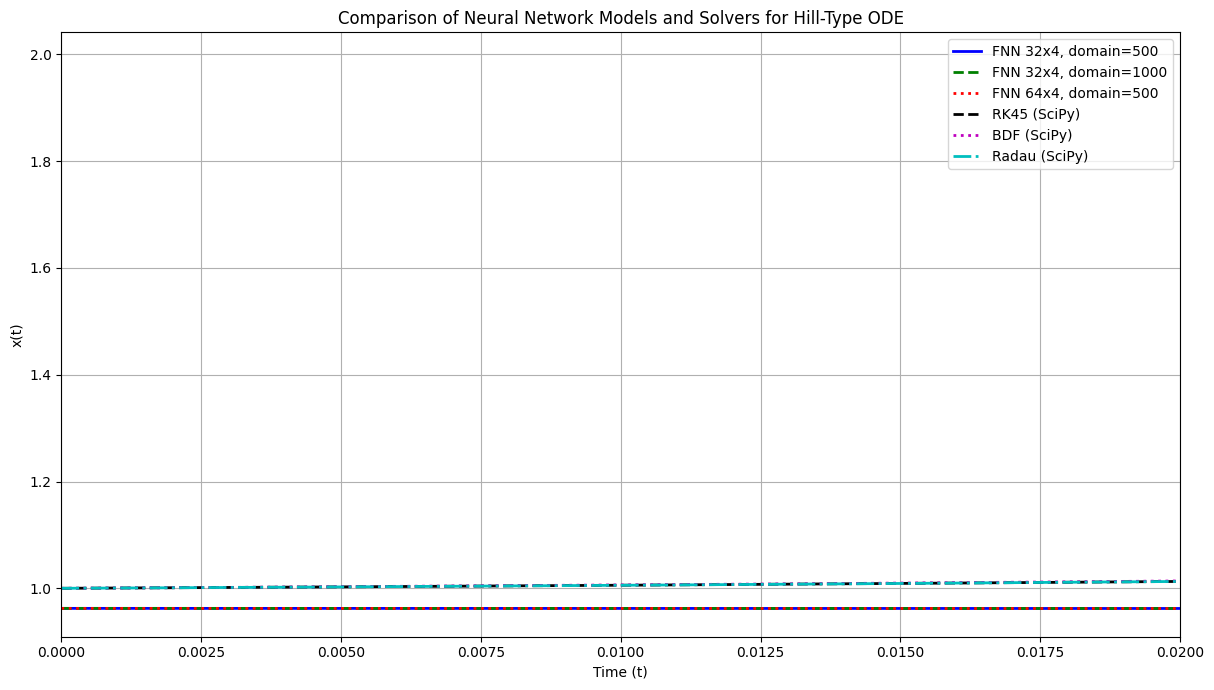

In [10]:
# ODE definition with Hill-like RHS
def hill_equation(x, y):
    y_safe = tf.clip_by_value(y, 1e-6, 1e6)
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)
    x_alpha = tf.pow(y_safe, 1 / alpha)
    b_alpha = tf.pow(b, 1 / alpha)
    return dy_t - x_alpha / (b_alpha + x_alpha)

geom = dde.geometry.TimeDomain(0, 1)
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

#configs = [
#    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
#    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
#    (500, [1] + [128] * 6 + [1], "FNN 128x6, domain=500"),
#    (1000, [1] + [128] * 6 + [1], "FNN 128x6, domain=1000"),
#    (500, [1] + [128] * 8 + [1], "FNN 128x8, domain=500"),
#    (1000, [1] + [128] * 8 + [1], "FNN 128x8, domain=1000")
#]

configs = [
    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
    (500, [1] + [64] * 4 + [1], "FNN 64x4, domain=500"),
]

# Non-uniform test points: dense near t=0
N = 500
t_uniform = np.linspace(0, 1, N)
t_test = t_uniform ** nonuniformity_power
t_test = np.unique(t_test).reshape(-1, 1)

# Define RHS for solvers
def rhs(t, x):
    x_safe = np.clip(x[0], 1e-6, 1e6)
    x_alpha = x_safe ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return [x_alpha / (b_alpha + x_alpha)]

# Solve using different methods
t_eval = np.sort(t_test.flatten())
sol_rk45 = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method='RK45')
sol_bdf = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method='BDF')
sol_radau = solve_ivp(rhs, [0, 1], [x0], t_eval=t_eval, method='Radau')

# Show some sample values in console
print("\nSample RK45 values:")
print(sol_rk45.t[:5], sol_rk45.y[0][:5])
print("\nSample BDF values:")
print(sol_bdf.t[:5], sol_bdf.y[0][:5])
print("\nSample Radau values:")
print(sol_radau.t[:5], sol_radau.y[0][:5])

# Define styles and colors
styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
colors = ['b', 'g', 'r', 'c', 'm', 'k']

# Train and evaluate neural models
results = []
all_losses = []


for alpha in alpha_list:
  print(f"\n=== Training for alpha = {alpha:.5e} ===")
  def rhs(t, x):
    x_safe = np.clip(x[0], 1e-6, 1e6)
    x_alpha = x_safe ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return [x_alpha / (b_alpha + x_alpha)]

  for i, (num_domain, architecture, label) in enumerate(configs):
    print(f"\nTraining model: {label}")
    data = dde.data.PDE(
        geom,
        hill_equation,
        ic,
        num_domain=num_domain,
        num_boundary=2,
        num_test=500
    )
    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")
    net.apply_output_transform(lambda x, y: y * 0.01 + b)
    model = dde.Model(data, net)
    model.compile("adam", lr=0.0001)
    loss_history, train_state = model.train(
        iterations=5000,
        display_every=1000,
        disregard_previous_best=True
    )
    try:
        model.compile("L-BFGS")
        model.train(iterations=500)
    except Exception as e:
        print(f"L-BFGS failed for {label}: {str(e)}")
    x_pred = model.predict(t_test)
    results.append((t_test, x_pred, label))
    all_losses.append((label, loss_history))
    print(f"{label}: min={np.nanmin(x_pred):.4f}, max={np.nanmax(x_pred):.4f}")

# Plot loss histories
plt.figure(figsize=(10, 6))
for label, loss_history in all_losses:
    plt.plot(loss_history.steps, loss_history.loss_train, label=f"{label} train loss")
    plt.plot(loss_history.steps, loss_history.loss_test, '--', label=f"{label} test loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot results
plt.figure(figsize=(12, 7))
for i, (t_vals, x_vals, label) in enumerate(results):
    plt.plot(t_vals, x_vals, linestyle=styles[i % len(styles)], color=colors[i % len(colors)], label=label, linewidth=2)

# Add numerical solutions
plt.plot(sol_rk45.t, sol_rk45.y[0], 'k--', label='RK45 (SciPy)', linewidth=2)
plt.plot(sol_bdf.t, sol_bdf.y[0], 'm:', label='BDF (SciPy)', linewidth=2)
plt.plot(sol_radau.t, sol_radau.y[0], 'c-.', label='Radau (SciPy)', linewidth=2)

# Axis and title
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models and Solvers for Hill-Type ODE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 0.02)
plt.show()